<a href="https://colab.research.google.com/github/ShreyaMandot/Topic-Modelling-Using-LDA-Top2Vec-BERTopic/blob/main/LDA_unigram_bigram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import os.path
import re
import spacy
import pandas as pd
from gensim import corpora
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pprint
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from pprint import pprint

In [4]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily', 'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may', 'take', 'come'])


df=pd.read_csv('Clean_Tweets.csv')
tweets_df=df.loc[:,['new_text']]
#tweets_df.info()
tweets_df['new_text']= df['new_text'].str.lower()


In [7]:
def sent_to_words(sentences):
    for sent in sentences:
        sent = re.sub('\S*@\S*\s?', '', str(sent))  # remove emails
        sent = re.sub('\s+', ' ', str(sent))  # remove newline chars
        sent = re.sub("\'", "", str(sent))  # remove single quotes
        sent = gensim.utils.simple_preprocess(str(sent), deacc=True) 
        yield(sent) 

In [8]:
data = tweets_df.new_text.values.tolist()
data_words = list(sent_to_words(data))
print(data_words[:1])


[['days', 'into', 'escitalopram', 'withdrawal', 'and', 'feel', 'so', 'sick']]


In [9]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)



/usr/local/lib/python3.8/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [10]:

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

#def make_trigrams(texts):
    #return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])


[['day', 'withdrawal', 'feel', 'sick']]


In [11]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])


lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=65, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=2,
                                           per_word_topics=True)



pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]




[[(0, 1), (1, 1), (2, 1), (3, 1)]]
[(8,
  '0.377*"make" + 0.069*"drink" + 0.042*"amount" + 0.032*"twice" + '
  '0.032*"small" + 0.029*"medicine" + 0.029*"grow" + 0.019*"energy" + '
  '0.015*"confused" + 0.014*"cum"'),
 (17,
  '0.170*"cause" + 0.116*"lexapro" + 0.113*"patient" + 0.081*"consider" + '
  '0.043*"fact" + 0.037*"story" + 0.021*"citalopram" + 0.020*"true" + '
  '0.020*"celexa" + 0.020*"funny"'),
 (28,
  '0.298*"use" + 0.077*"withdrawal" + 0.048*"half" + 0.044*"often" + '
  '0.043*"already" + 0.037*"stuff" + 0.028*"ass" + 0.025*"honestly" + '
  '0.024*"expensive" + 0.021*"tomorrow"'),
 (63,
  '0.120*"spectrum_cable" + 0.116*"order" + 0.060*"manager_rivero" + '
  '0.040*"ketamine" + 0.034*"read" + 0.033*"queens_new" + 0.026*"clinic" + '
  '0.024*"tonight" + 0.022*"phone" + 0.021*"age"'),
 (64,
  '0.234*"depression" + 0.180*"year" + 0.067*"come" + 0.066*"less" + '
  '0.042*"effectiveness" + 0.026*"oral" + 0.026*"however" + 0.024*"wild" + '
  '0.021*"article" + 0.019*"single"'),


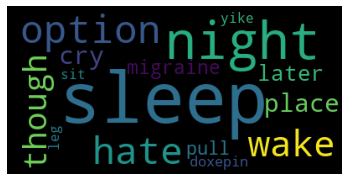

In [17]:
from wordcloud import WordCloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(dict(lda_model.show_topic(50, topn=15)))

# Display the wordcloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

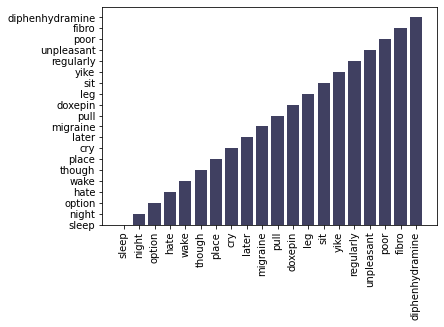

In [14]:
import numpy as np
topic_0_words = lda_model.show_topic(topicid=50, topn=20)
topic_0_words = [word for word, prob in topic_0_words]

# Create the bar chart
plt.bar(range(len(topic_0_words)), topic_0_words,color=np.random.rand(3,) )
plt.xticks(range(len(topic_0_words)), topic_0_words, rotation='vertical')
plt.show()

In [12]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)




Perplexity:  -11.559604139163373

Coherence Score:  0.5526368347569696


In [13]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,24.0,0.4031,"day, feel, start, take, figure, extra, gratefu...","[day, withdrawal, feel, sick]"
1,1,10.0,0.8031,"go, change, buy, love, personal, soon, convinc...","[go, convince, change, soon]"
2,2,19.0,0.2031,"call, let, mix, save, trouble, long_term, flyn...","[wait, escitalopram, poise, kill]"
3,3,4.0,0.2538,"doctor, say, pill, system, escitalopram, twitt...","[exam, amp, escitalopram]"
4,4,54.0,0.5798,"amp, wait, focus, word, thank, behavior, quest...","[thank, balanced, arm, randomise, escitalopram..."
5,5,49.0,0.6924,"emsam, effect, need, man, response, refer, adu...","[effect, escitalopram, treatment, chronic, mil..."
6,6,49.0,0.7626,"emsam, effect, need, man, response, refer, adu...","[nephrosafe, escitalopram, sertraline, safe, t..."
7,7,9.0,0.4462,"thing, enough, shit, disorder, forget, induce,...","[never, really, shit, m, low_dose, thing, take..."
8,8,49.0,0.3385,"emsam, effect, need, man, response, refer, adu...","[fix, lexapro]"
9,9,19.0,0.4559,"call, let, mix, save, trouble, long_term, flyn...","[m, bipolar, amp, lithium, amp, escitalopram, ..."


In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis=pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word, mds="mmds", R=20 )
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
61    -0.287514 -0.388539       1        1  2.314560
27    -0.360687  0.348232       2        1  2.142161
49     0.127974  0.464269       3        1  2.140280
51    -0.441176  0.143372       4        1  2.122839
40    -0.483739  0.041729       5        1  2.109868
...         ...       ...     ...      ...       ...
44     0.286095  0.011494      61        1  1.138815
59     0.430583  0.017020      62        1  1.138362
30     0.148436  0.216800      63        1  1.134249
9      0.238772 -0.148248      64        1  1.129893
56     0.097625 -0.039119      65        1  0.987392

[65 rows x 5 columns], topic_info=            Term         Freq        Total Category  logprob  loglift
213   wellbutrin  1228.000000  1228.000000  Default  20.0000  20.0000
59          take  1143.000000  1143.000000  Default  19.0000  19.0000
12           amp   659.000000   659.000000  Default  18.0000  18.0000
146         help   584.000000   584.000000  Default  17.0000  17.0000
817        study   525.000000   525.000000  Default  16.0000  16.0000
...          ...          ...          ...      ...      ...      ...
1706    overdose    11.809935    12.643752  Topic65  -4.3373   4.5496
2944    instance    10.735796    11.569614  Topic65  -4.4327   4.5431
2507      rarely    10.684029    11.517846  Topic65  -4.4375   4.5427
1719     illegal     9.875590    10.709408  Topic65  -4.5162   4.5368
9983  revelation    10.132147    11.409881  Topic65  -4.4906   4.4991

[1362 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
983       8  0.968364     abilify
525      38  0.984702        able
4650     22  0.919170    absolute
1031     62  0.986089  absolutely
5173     20  0.984294    abstract
...     ...       ...         ...
775      17  0.974345         yet
3595     12  0.924905        yike
6298     14  0.989610  york_state
3896     27  0.980408          yr
1111     11  0.993256      zoloft

[1402 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[62, 28, 50, 52, 41, 30, 44, 32, 48, 58, 39, 11, 37, 15, 14, 7, 51, 40, 59, 16, 27, 63, 23, 47, 42, 17, 61, 8, 13, 1, 9, 19, 20, 2, 4, 3, 26, 12, 18, 54, 22, 24, 55, 49, 34, 29, 46, 56, 35, 38, 5, 43, 33, 25, 65, 36, 21, 53, 64, 6, 45, 60, 31, 10, 57])